# Determinants of Urban House Prices : Evidence from Berlin

as part of the course **Financial Data Analytics in Python**  
**Prof. Dr. Fabian Woebbeking**


Submitted by : **Morteza Motegh (222235729)**  
MLU - Martin Luther University Halle-Wittenberg

morteza.motegh@student.uni-halle.de

# Course Work: Berlin

## 1. Web Scrapping

In [75]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


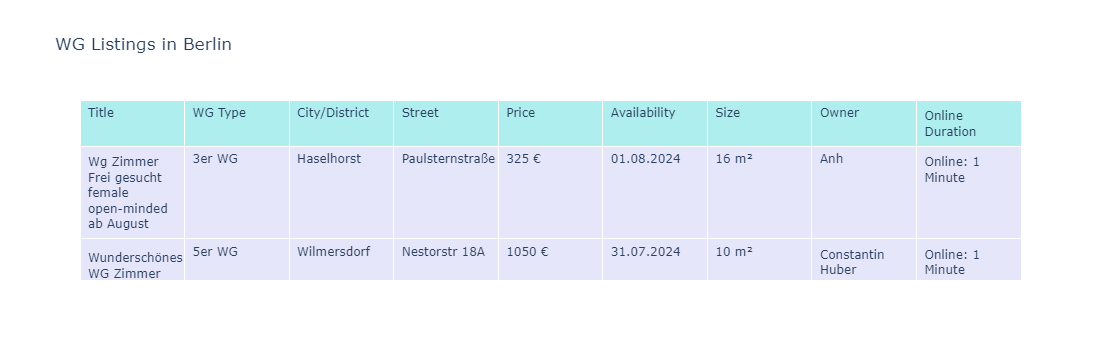

In [60]:
# Import Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import plotly.graph_objects as go

# Functions for Web Scraping
def get_wg_listings(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def parse_listing(listing):
    title = listing.find('h3', class_='truncate_title noprint')
    location = listing.find('div', class_='col-xs-11')
    price = listing.find('div', class_='col-xs-3')
    availability = listing.find('div', class_='col-xs-5 text-center')
    size = listing.find('div', class_='col-xs-3 text-right')

    # Using BeautifulSoup to locate owner and online duration
    owner = listing.find('span', class_='ml5')
    online_duration = listing.find('span', style='color: #218700;')

    # Extracting location information
    location_text = location.text.strip() if location else None
    wg_type, district, street = None, None, None

    if location_text:
        location_parts = [part.strip() for part in location_text.split("|")]
        if len(location_parts) == 3:
            wg_type, city_district, street = location_parts
        elif len(location_parts) == 2:
            wg_type, city_district = location_parts
        elif len(location_parts) == 1:
            wg_type = location_parts[0]

        if city_district and "Berlin" in city_district:
            district = city_district.replace("Berlin", "").strip()

    # Remove extra spaces between dates in availability
    availability_text = availability.text.strip().replace(' ', '') if availability else None

    data = {
        'Title': title.text.strip() if title else None,
        'WG Type': wg_type,
        'City/District': district,
        'Street': street,
        'Price': f"{price.text.strip().replace('€', '').replace(' ', '')} €" if price else None,
        'Availability': availability_text,
        'Size': f"{size.text.strip().replace('m²', '').replace(' ', '')} m²" if size else None,
        'Owner': owner.text.strip() if owner else None,
        'Online Duration': online_duration.text.strip() if online_duration else None
    }

    return data

def scrape_wg_data(base_url, num_listings):
    listings_data = []
    page = 0

    while len(listings_data) < num_listings:
        url = f"{base_url}?page={page}"
        soup = get_wg_listings(url)
        listings = soup.find_all('div', class_='offer_list_item')
        
        if not listings:
            break

        for listing in listings:
            data = parse_listing(listing)
            listings_data.append(data)
            if len(listings_data) >= num_listings:
                break

        page += 1
        time.sleep(1)  # To avoid overwhelming the server with requests

    df = pd.DataFrame(listings_data)
    return df

# Data Scraping
BASE_URL = 'https://www.wg-gesucht.de/wg-zimmer-in-Berlin.8.0.1.0.html'
NUM_LISTINGS = 200
wg_data_df = scrape_wg_data(BASE_URL, NUM_LISTINGS)

# Data Visualization and Saving
fig = go.Figure(data=[go.Table(
    header=dict(values=list(wg_data_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[wg_data_df[col] for col in wg_data_df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title='WG Listings in Berlin')
fig.show()

# Save the DataFrame to an Excel file
wg_data_df.to_excel('wg_listings_berlin.xlsx', index=False)

## 2. Data Modification for Analysis

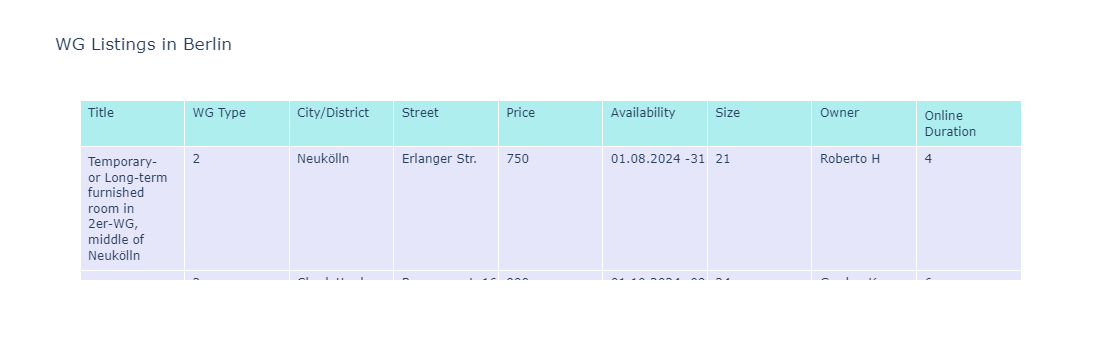

In [33]:
# Import Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import plotly.express as px
import statsmodels.api as sm

# Functions for Web Scraping
def get_wg_listings(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def parse_listing(listing):
    title = listing.find('h3', class_='truncate_title noprint')
    location = listing.find('div', class_='col-xs-11')
    price = listing.find('div', class_='col-xs-3')
    availability = listing.find('div', class_='col-xs-5 text-center')
    size = listing.find('div', class_='col-xs-3 text-right')

    # Using BeautifulSoup to locate owner and online duration
    owner = listing.find('span', class_='ml5')
    online_duration = listing.find('span', style='color: #218700;')

    # Extracting location information
    location_text = location.text.strip() if location else None
    wg_type, district, street = None, None, None

    if location_text:
        location_parts = [part.strip() for part in location_text.split("|")]
        if len(location_parts) == 3:
            wg_type, city_district, street = location_parts
        elif len(location_parts) == 2:
            wg_type, city_district = location_parts
        elif len(location_parts) == 1:
            wg_type = location_parts[0]

        if city_district and "Berlin" in city_district:
            district = city_district.replace("Berlin", "").strip()

    # Remove extra spaces between dates in availability
    availability_text = availability.text.strip().replace(' ', '') if availability else None

    # Extract numeric value from online duration
    online_duration_text = online_duration.text.strip() if online_duration else None
    online_duration_numeric = int(''.join(filter(str.isdigit, online_duration_text))) if online_duration_text else None

    data = {
        'Title': title.text.strip() if title else None,
        'WG Type': wg_type,
        'City/District': district,
        'Street': street,
        'Price': f"{price.text.strip().replace('€', '').replace(' ', '')}" if price else None,
        'Availability': availability_text,
        'Size': f"{size.text.strip().replace('m²', '').replace(' ', '')}" if size else None,
        'Owner': owner.text.strip() if owner else None,
        'Online Duration': online_duration_numeric
    }

    return data

def scrape_wg_data(base_url, num_listings):
    listings_data = []
    page = 0

    while len(listings_data) < num_listings:
        url = f"{base_url}?page={page}"
        soup = get_wg_listings(url)
        listings = soup.find_all('div', class_='offer_list_item')
        
        if not listings:
            break

        for listing in listings:
            data = parse_listing(listing)
            listings_data.append(data)
            if len(listings_data) >= num_listings:
                break

        page += 1
        time.sleep(1)  # To avoid overwhelming the server with requests

    df = pd.DataFrame(listings_data)
    return df

# Data Scraping and Modification
# Scrape data
BASE_URL = 'https://www.wg-gesucht.de/wg-zimmer-in-Berlin.8.0.1.0.html'
NUM_LISTINGS = 500
wg_data_df = scrape_wg_data(BASE_URL, NUM_LISTINGS)

# Modify data
wg_data_df['WG Type'] = wg_data_df['WG Type'].str.extract(r'(\d)').astype(float)
wg_data_df['Price'] = pd.to_numeric(wg_data_df['Price'], errors='coerce')
wg_data_df['Size'] = pd.to_numeric(wg_data_df['Size'], errors='coerce')
wg_data_df['Online Duration'] = pd.to_numeric(wg_data_df['Online Duration'], errors='coerce')

# Drop rows with missing values in relevant columns
wg_data_df.dropna(subset=['Price', 'Size', 'WG Type', 'Online Duration'], inplace=True)

# Data Visualization and Saving
fig = go.Figure(data=[go.Table(
    header=dict(values=list(wg_data_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[wg_data_df[col] for col in wg_data_df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title='WG Listings in Berlin')
fig.show()

# Save the DataFrame to an Excel file
wg_data_df.to_excel('wg_listings_berlin_modified.xlsx', index=False)

## 3. Descriptive Statistics

In [34]:
# The entire DataFrame

print("Descriptive Statistics for the entire DataFrame:")
print(wg_data_df.describe().map(lambda x: f'{x:.0f}'))

Descriptive Statistics for the entire DataFrame:
      WG Type Price Size Online Duration
count     413   413  413             413
mean        3   624   17              11
std         1   168    4               5
min         1   295   10               1
25%         2   520   15               8
50%         3   610   17              10
75%         3   750   20              14
max         6  1020   25              18


In [35]:
# Count occurrences for WG Type

print("\nCount of occurrences for WG Type:")
print(wg_data_df['WG Type'].value_counts().apply(lambda x: f'{x:.0f}'))


Count of occurrences for WG Type:
WG Type
3.0    149
2.0    132
4.0     56
1.0     38
5.0     19
6.0     19
Name: count, dtype: object


In [36]:
# Price 

print("\nDescriptive Statistics for Price:")
print(wg_data_df['Price'].describe().apply(lambda x: f'{x:.0f}'))


Descriptive Statistics for Price:
count     413
mean      624
std       168
min       295
25%       520
50%       610
75%       750
max      1020
Name: Price, dtype: object


In [37]:
# Size 

print("\nDescriptive Statistics for Size:")
print(wg_data_df['Size'].describe().apply(lambda x: f'{x:.0f}'))


Descriptive Statistics for Size:
count    413
mean      17
std        4
min       10
25%       15
50%       17
75%       20
max       25
Name: Size, dtype: object


In [38]:
#Online Duration 

print("\nDescriptive Statistics for Online Duration:")
print(wg_data_df['Online Duration'].describe().apply(lambda x: f'{x:.0f}'))


Descriptive Statistics for Online Duration:
count    413
mean      11
std        5
min        1
25%        8
50%       10
75%       14
max       18
Name: Online Duration, dtype: object


## 4. Correlation Matrix

Correlation Matrix:
                 Price   Size WG Type Online Duration
Price             1.00   0.39   -0.05           -0.28
Size              0.39   1.00   -0.17           -0.04
WG Type          -0.05  -0.17    1.00            0.12
Online Duration  -0.28  -0.04    0.12            1.00


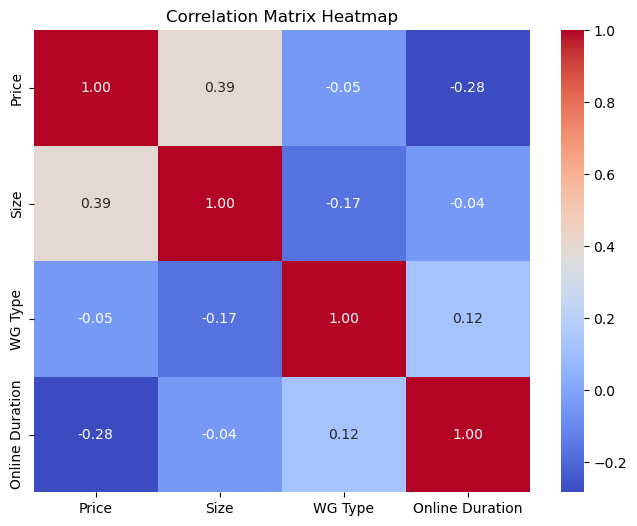

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = wg_data_df[['Price', 'Size', 'WG Type', 'Online Duration']].corr()

print("Correlation Matrix:")
print(correlation_matrix.map(lambda x: f'{x:.2f}'))

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


## 6. Distribution Analysis

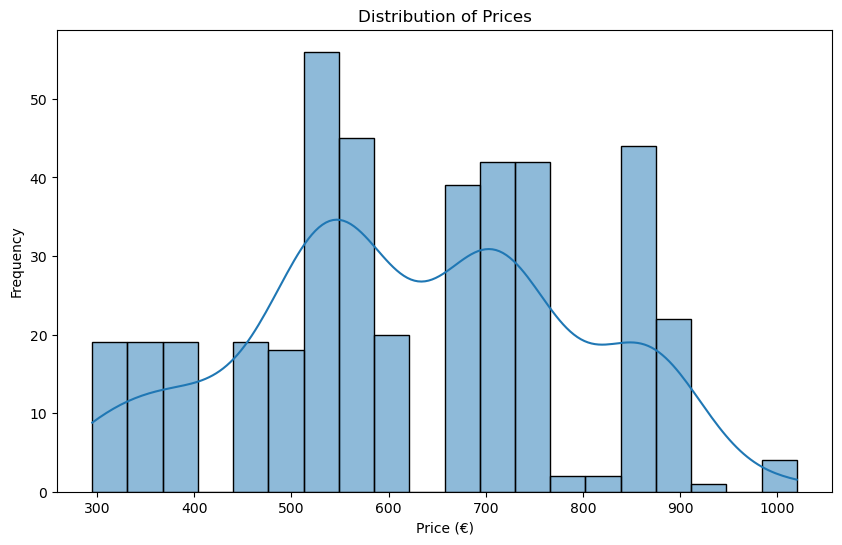

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Price
plt.figure(figsize=(10, 6))
sns.histplot(wg_data_df['Price'], bins=20, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')
plt.show()

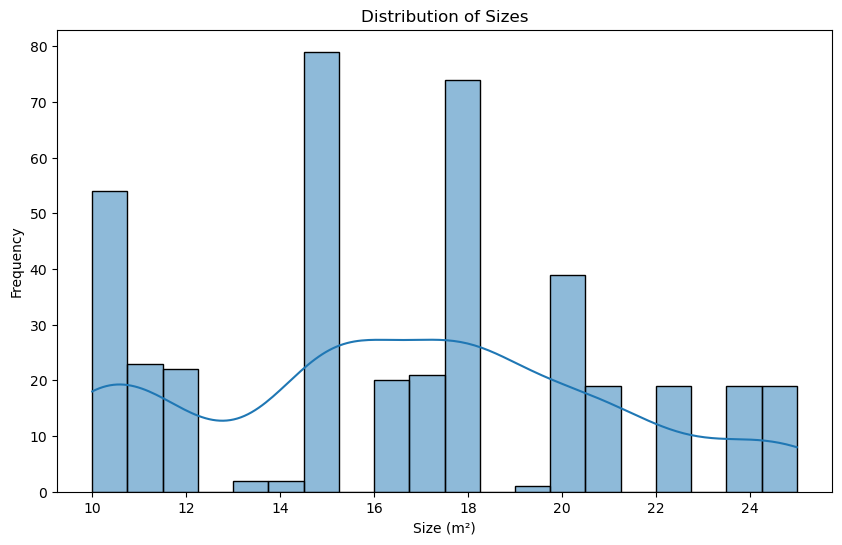

In [41]:
# Histogram for Size
plt.figure(figsize=(10, 6))
sns.histplot(wg_data_df['Size'], bins=20, kde=True)
plt.title('Distribution of Sizes')
plt.xlabel('Size (m²)')
plt.ylabel('Frequency')
plt.show()

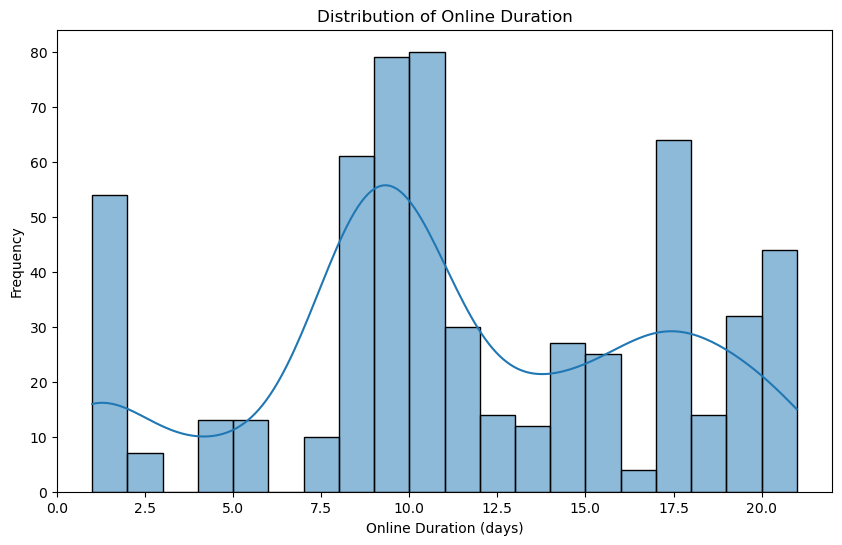

In [26]:
# Histogram for Online Duration
plt.figure(figsize=(10, 6))
sns.histplot(wg_data_df['Online Duration'], bins=20, kde=True)
plt.title('Distribution of Online Duration')
plt.xlabel('Online Duration (days)')
plt.ylabel('Frequency')
plt.show()

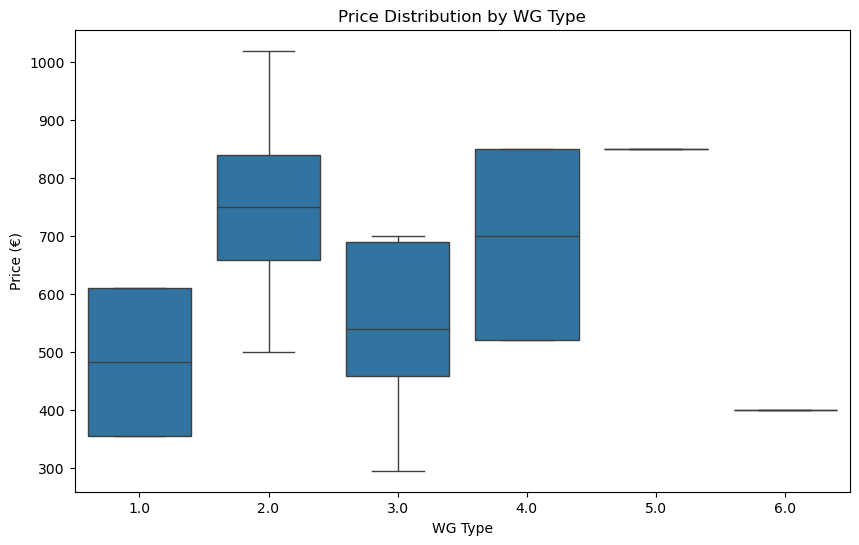

In [42]:
# Box plot for Price by WG Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='WG Type', y='Price', data=wg_data_df)
plt.title('Price Distribution by WG Type')
plt.xlabel('WG Type')
plt.ylabel('Price (€)')
plt.show()

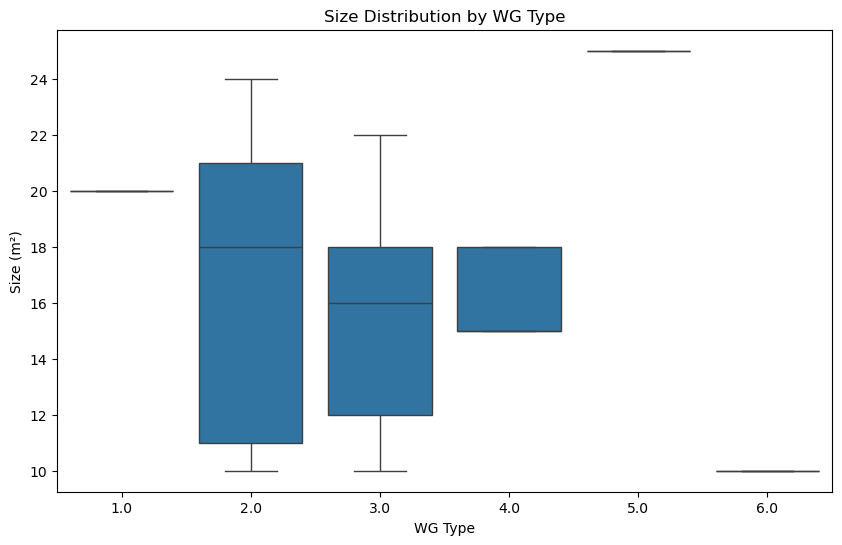

In [43]:
# Box plot for Size by WG Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='WG Type', y='Size', data=wg_data_df)
plt.title('Size Distribution by WG Type')
plt.xlabel('WG Type')
plt.ylabel('Size (m²)')
plt.show()

## 7. Regression analysis

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     40.44
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           6.66e-23
Time:                        13:07:00   Log-Likelihood:                -2647.6
No. Observations:                 413   AIC:                             5303.
Df Residuals:                     409   BIC:                             5319.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             454.3953     39.834     

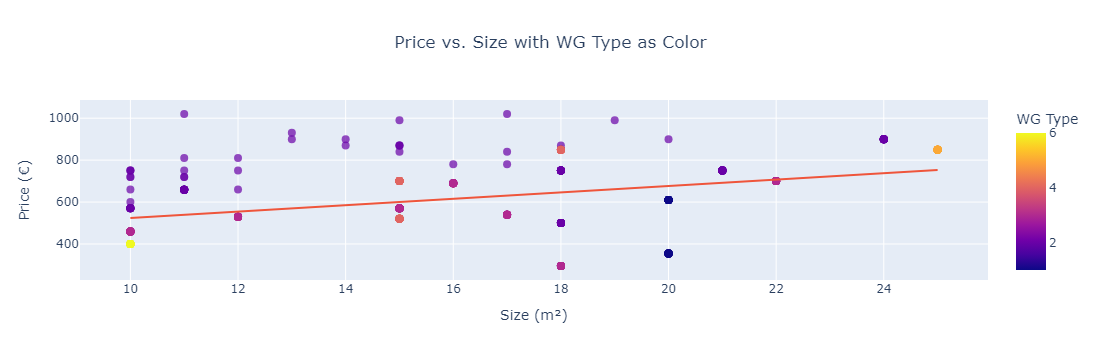

In [58]:
import statsmodels.api as sm
import plotly.express as px

# Define the explained and explanatory variables
X = wg_data_df[['Size', 'WG Type', 'Online Duration']]
y = wg_data_df['Price']

# Add a constant 
X = sm.add_constant(X)

# Perform the OLS 
model = sm.OLS(y, X).fit()

# Print the OLS  
print(model.summary())

# Convert the summary to a DataFrame and save to CSV
summary_html = model.summary().tables[1].as_html()
summary_df = pd.read_html(StringIO(summary_html), header=0, index_col=0)[0]
summary_df.to_csv('ols_Price_summary.csv')

# Alternatively, save just the coefficients and p-values
coefficients = model.params
p_values = model.pvalues
results_df = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values})
results_df.to_csv('ols_Price_coefficients_pvalues.csv', index=True)

# estimation plot 
fig = px.scatter(wg_data_df, x='Size', y='Price', color='WG Type', 
                 trendline='ols', 
                 labels={'Size': 'Size (m²)', 'Price': 'Price (€)', 'WG Type': 'WG Type'},
                 title='Price vs. Size with WG Type as Color')

fig.update_traces(marker=dict(size=8, opacity=0.7),
                  selector=dict(mode='markers'))

fig.update_layout(legend_title_text='WG Type',
                  xaxis_title='Size (m²)',
                  yaxis_title='Price (€)',
                  title={
                      'text': 'Price vs. Size with WG Type as Color',
                      'y':0.9,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})

fig.show()

#### Interpretation : 
Intercept (**454**): When Size and WG Type are zero, the average Price is approximately **454** euros.  

Size (**15**): For each additional square meter, the Price increases by approximately **15** euros, which is statistically significant.  

WG Type (**7**): For each additional room in the WG (WG Type), the Price increases by approximately **7** euros, which is statistically significant. 

Online duration (**-9**): Each additional minute , decrease the price about **9** euros.

Overall Model: The model explains about **22%** of the variance in prices.

                            OLS Regression Results                            
Dep. Variable:        Online Duration   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     15.38
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           1.69e-09
Time:                        13:07:06   Log-Likelihood:                -1199.1
No. Observations:                 413   AIC:                             2406.
Df Residuals:                     409   BIC:                             2422.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8594      1.215     10.585      0.0

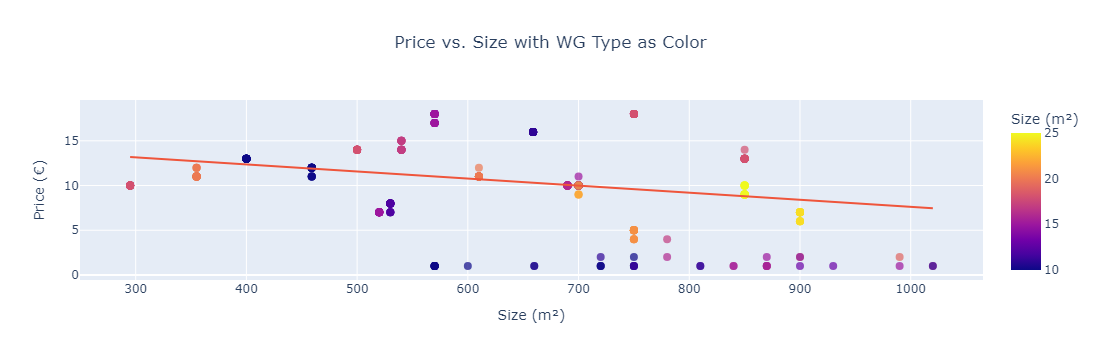

In [59]:
import statsmodels.api as sm
import plotly.express as px

# Define the explained and explanatory variables
X = wg_data_df[['Size', 'WG Type', 'Price']]
y = wg_data_df['Online Duration']

# Add a constant
X = sm.add_constant(X)

# Perform the OLS 
model = sm.OLS(y, X).fit()

# Print the OLS 
print(model.summary())

# Convert the summary to a DataFrame and save to CSV
summary_html = model.summary().tables[1].as_html()
summary_df = pd.read_html(StringIO(summary_html), header=0, index_col=0)[0]
summary_df.to_csv('ols_OnlineDuration_summary.csv')

# Alternatively, save just the coefficients and p-values
coefficients = model.params
p_values = model.pvalues
results_df = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values})
results_df.to_csv('ols_OnlineDuration_coefficients_pvalues.csv', index=True)

# estimation plot
fig = px.scatter(wg_data_df, x='Price', y='Online Duration', color='Size', 
                 trendline='ols', 
                 labels={'Size': 'Size (m²)', 'Price': 'Price (€)', 'WG Type': 'WG Type'},
                 title='Price vs. Size with WG Type as Color')

fig.update_traces(marker=dict(size=8, opacity=0.7),
                  selector=dict(mode='markers'))

fig.update_layout(legend_title_text='WG Type',
                  xaxis_title='Size (m²)',
                  yaxis_title='Price (€)',
                  title={
                      'text': 'Price vs. Size with WG Type as Color',
                      'y':0.9,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})

fig.show()

### Interpretation : 
Intercept (**12**): This suggests that the base value of online duration, when all other predictors are zero, is approximately 9 minutes.  

Size (**0.1**): Each additional square meter of size increase the online duration by approximately 0.01 minutes, indicating that larger properties tend to be rented or decided upon more quickly.  

WG Type (**0.4**): Each additional room can increase the online duration by about 0.4 minutes.  

Price (**-0.008**): The effect of price on online duration is negative but not statistically significant

Overall Model: The model explains about **12%** of the variance in prices.